In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
from PIL import Image

In [21]:

def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

def get_receipt_contour(contours):    
    for c in contours:
        approx = approximate_contour(c)
        print(len(approx))
        # four points = rectangle
        if len(approx) == 4:
            print(f"taken:{len(approx)}")
            return approx


def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255


approx


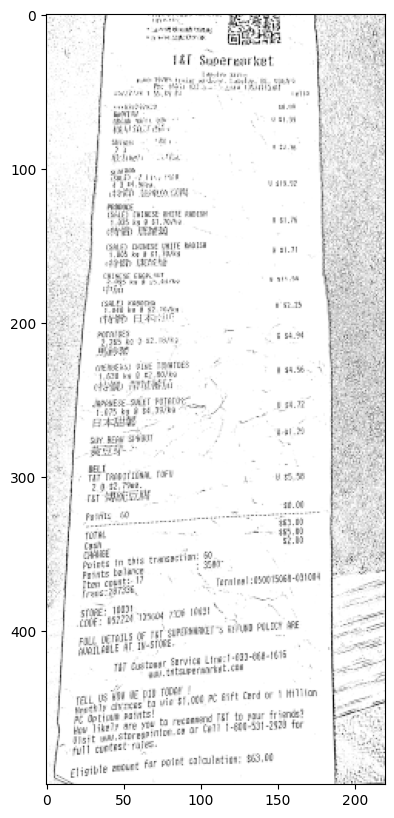

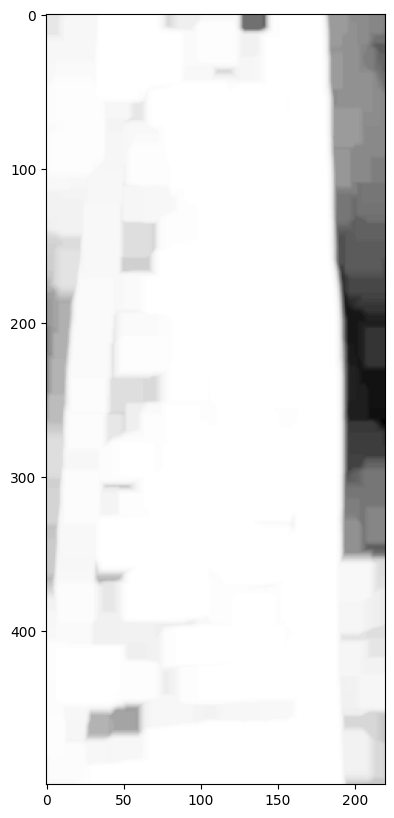

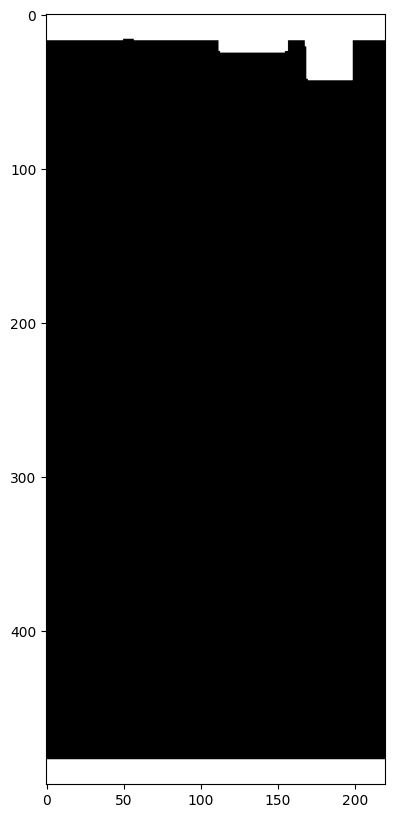

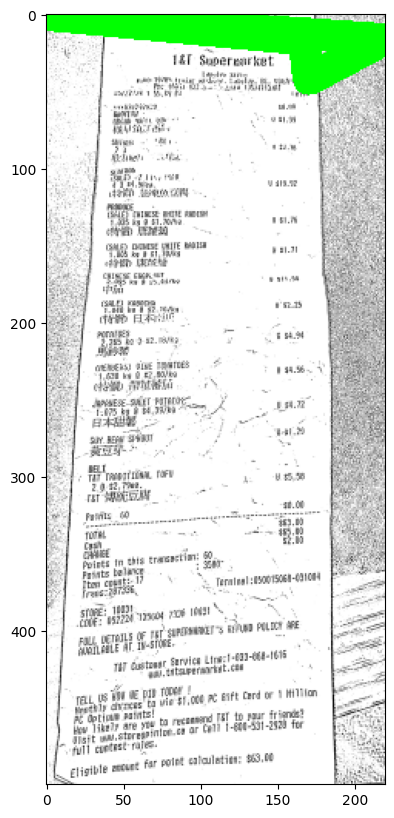

In [66]:

# path = r"D:\photos\large reciept images\1092-receipt.jpg"
path = r"D:\photos\Image_202407042318302.jpg"
# path = r"D:\photos\Image_202407042318301.jpg"
# path = r"D:\photos\Image_202407042318222.jpg"
path = r"D:\photos\large reciept images\1079-receipt.jpg"
path = r"D:\photos\large reciept images\1083-receipt.jpg"
# path = r"D:\photos\large reciept images\1000-receipt.jpg"
# path = r"D:\photos\large reciept images\1106-receipt.jpg"
# path = r"D:\photos\large reciept images\1094-receipt.jpg"
path = r"D:\photos\processed_receipts\211.png"
# Add a border to the image
def add_border(image, border_size=1):
    bordered_image = image.copy()

    height, width = image.shape[:2]
    color = [0, 0, 0]  # White border for visibility
    start_x = (width - 500) // 2  # Center the border horizontally
    end_x = start_x + 500
    cv2.rectangle(bordered_image, (start_x, 0), (end_x, border_size), color, -1)
    cv2.rectangle(bordered_image, (start_x, height - border_size), (end_x, height), color, -1)
    # color = [255, 255, 255]
    return bordered_image
# Load and add border
image = cv2.imread(path)
# height, _ = image.shape[:2]
# margin_size = 100
# image = image[margin_size:height - margin_size, :]
# image = add_border(image)
original = image.copy()
# Downscale image 
resize_ratio = 500 / image.shape[0]

image = opencv_resize(image, resize_ratio)
# Convert to grayscale 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)
# Get rid of noise 
blurred = cv2.GaussianBlur(gray, (15, 15), 0) 
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
dilated = cv2.dilate(blurred, rectKernel, iterations=2)
plot_gray(dilated)
dilated = add_border(dilated)

edged = cv2.Canny(dilated, 75, 200, apertureSize=3)
# plot_gray(edged)

# # Apply morphological operations to close gaps between contours
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # Adjust kernel size as needed
# closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
# # plot_gray(closed)

threshold = np.mean(edged)
thresh, binary = cv2.threshold(edged, threshold, 255, cv2.THRESH_BINARY)
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
proccessed_edge = cv2.dilate(binary, rectKernel, iterations=2)
plot_gray(proccessed_edge)

def find_receipt_bounding_box(binary, img):
    global largest_cnt
    contours, hierarchy = cv2.findContours(
        binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    largest_cnt = max(contours, key=cv2.contourArea)
    epsilon = 0.032 * cv2.arcLength(largest_cnt, True)  # 2% of the contour perimeter
    approx = cv2.approxPolyDP(largest_cnt, epsilon, True)
    
    # Check if the approximated contour has four points
    if len(approx) == 4:
        box = approx  # The contour with four points
        print("approx")
    else:
        # If the approximation does not have four points, find the convex hull of the contour
        hull = cv2.convexHull(largest_cnt)
        epsilon = 0.02 * cv2.arcLength(hull, True)  # Adjust the epsilon for desired accuracy
        box = cv2.approxPolyDP(hull, epsilon, True)
        print("hull")
    boxed = cv2.drawContours(img.copy(), [box], 0, (0, 255, 0), 20)
    return boxed, box

boxed, receipt_contour = find_receipt_bounding_box(proccessed_edge, image)
boxed_rgb = cv2.cvtColor(boxed, cv2.COLOR_BGR2RGB)
plot_rgb(boxed_rgb)

In [64]:
# # Detect all contours 
# contours, hierarchy = cv2.findContours(proccessed_edge, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# print(len(contours))
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

# # Get 10 largest contours
# filtered_contours = [c for c in contours if cv2.contourArea(c) > 1000]
# largest_contours = sorted(filtered_contours, key = cv2.contourArea, reverse = True)[:10]
# receipt_contour = get_receipt_contour(largest_contours)
# image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
# plot_rgb(image_with_receipt_contour)

(1003, 749)


array([[  0,   0,   0, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

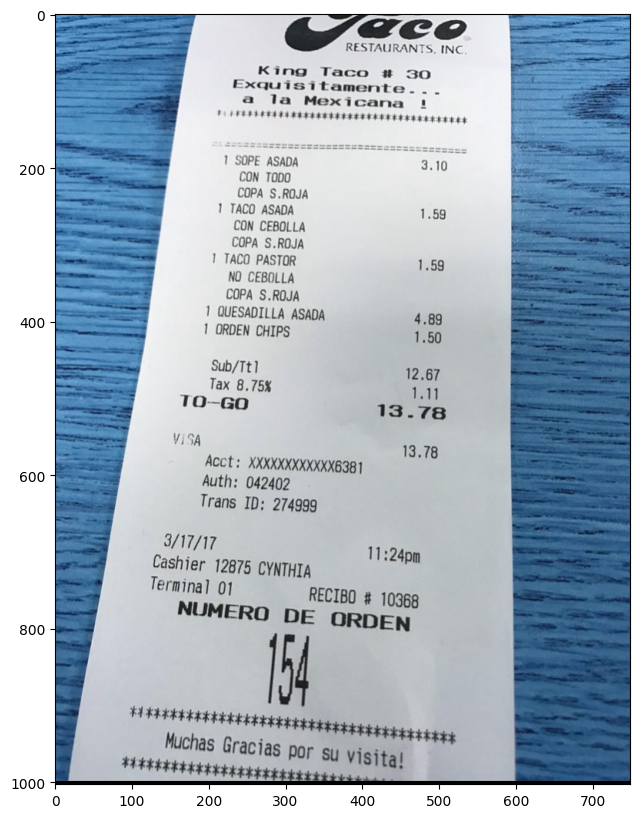

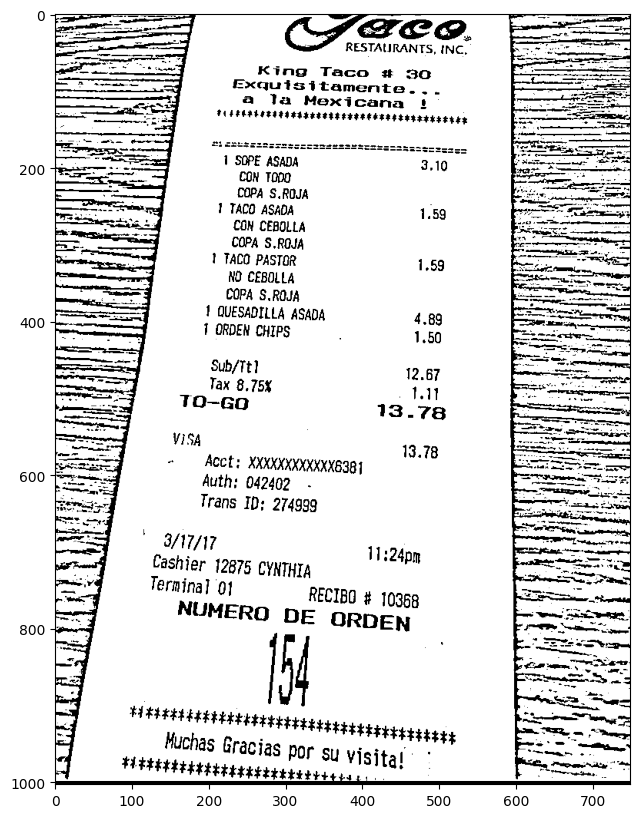

In [49]:
greyscale_output = np.array([])
try:
    original = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
    plt.figure(figsize=(16,10))
    plt.imshow(original)
    greyscale_output = bw_scanner(original)
except:
    print("nope error")

if greyscale_output.size == 0:
    print("empty")
print(greyscale_output.shape)
output = Image.fromarray(original)
# output.save('result.png')
plot_gray(greyscale_output)
greyscale_output